# Benchmark


In this notebook, we use pepme to evaluate antimicrobial peptide sequences.


In [ ]:
import pickle

import matplotlib.pyplot as plt
import numpy as np

from pepme import FeatureCache, compute_metrics, show_table
from pepme.metrics import FBD, ID, MMD, AuthPct, ConformityScore, Fold, Novelty, Precision, Recall, Uniqueness
from pepme.models import Charge, Esm2, Esm2Checkpoint, Gravy, HydrophobicMoment
from pepme.plots import plot_kde, plot_umap
from pepme.utils import random_subset, read_fasta_file, shuffle_sequences

## Data


Let's load the datasets.


In [ ]:
DATASET_PATHS = {
    # Databases
    "UniProt": "./data/uniprot/uniprot_8_50_100.fasta",
    "AMP-data": "./data/amps.fasta",
    "AMPs": "./data/amps_hq.fasta",
    "DBAASP": "./data/dbaasp.fasta",
    # Models
    "AMP-Diffusion": "./data/amp-diffusion.fasta",
    "AMP-GAN": "./data/amp-gan.fasta",
    "CPL-Diff": "./data/cpl-diff.fasta",
    "HydrAMP": "./data/hydramp.fasta",
    "OmegAMP": "./data/omegamp.fasta",
}

In [ ]:
datasets = {name: read_fasta_file(path) for name, path in DATASET_PATHS.items()}

In [ ]:
for model_name, sequences in datasets.items():
    print(f"{model_name}: {len(sequences)} sequences")

UniProt: 2933310 sequences
AMP-data: 37116 sequences
AMPs: 7204 sequences
DBAASP: 8967 sequences
AMP-Diffusion: 47671 sequences
AMP-GAN: 150000 sequences
CPL-Diff: 49985 sequences
HydrAMP: 50000 sequences
OmegAMP: 149504 sequences


Let's setup the data and models.


In [ ]:
sources = [
    "AMP-Diffusion",
    "AMP-GAN",
    "CPL-Diff",
    "HydrAMP",
    "OmegAMP",
    "UniProt",
]

n_samples = 40_000  # 3_000
seed = 42

benchmark_datasets = {
    source: random_subset(datasets[source], n_samples=n_samples, seed=seed)
    if len(sequences) > n_samples
    else datasets[source]
    for source in sources
}
# benchmark_datasets["DBAASP (shuffled)"] = shuffle_sequences(datasets["DBAASP"], seed=seed)

seqs_amps = datasets["AMPs"]
seqs_train = datasets["AMP-data"]

## Models


Let's load the models and set up the cache.


In [ ]:
CACHE_PATH = None  # "new_cache.pkl"

if CACHE_PATH:
    with open(CACHE_PATH, "rb") as f:
        init_cache = pickle.load(f)
else:
    init_cache = None

In [ ]:
def my_embedder(sequences: list[str]) -> np.ndarray:
    lengths = [len(sequence) for sequence in sequences]
    counts = [sequence.count("K") for sequence in sequences]
    return np.array([lengths, counts]).T


esm2 = Esm2(
    model_name=Esm2Checkpoint.t6_8M,
    batch_size=256,
    device="cpu",
    verbose=False,
)

cache = FeatureCache(
    models={
        "embedder": my_embedder,
        "esm2-embed": esm2.embed,
        "esm2-perplexity": lambda seqs: esm2.compute_pseudo_perplexity(seqs, mask_size=3),
        "gravy": Gravy(),
        "charge": Charge(),
        "amphiphilicity": HydrophobicMoment(),
    },
    init_cache=init_cache,
)

Let's look at the embeddings of the embedding model.

In [ ]:
datasets_to_plot_names = ["UniProt", "AMP-data"]
# @TODO: include shuffled AMP-data?

colors = ["red", "green"]

n_samples = 2_000
seed = 42

datasets_to_plot = {
    name: random_subset(datasets[name], n_samples=n_samples, seed=seed)
    if len(sequences) > n_samples
    else datasets[name]
    for name in datasets_to_plot_names
}

In [ ]:
embedder_name = "embedder"
embedder = cache.model(embedder_name)

embeddings = {name: embedder(dataset) for name, dataset in datasets_to_plot.items()}

/Users/rasmus.larsen/work/hackathon-2025/pepme/.conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


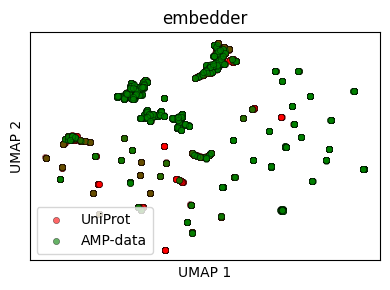

In [ ]:
plot_umap(embeddings.values(), list(embeddings.keys()), title=embedder_name, colors=colors)

## Metrics


In order to choose a good bandwidth for the kernel density estimator (KDE) in the conformity score, we plot the kde for the two properties of interest on the reference set (AMP dataset).


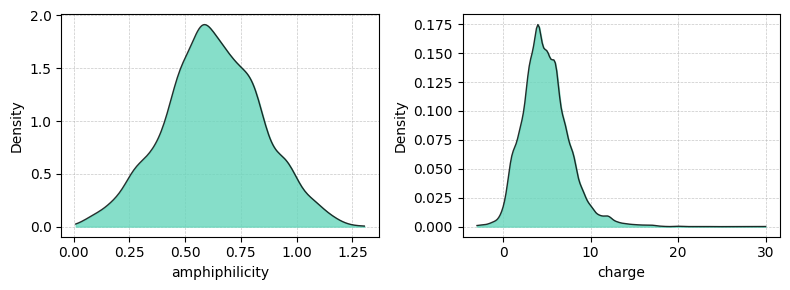

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

amphiphilicity = cache.model("amphiphilicity")
plot_kde(amphiphilicity(seqs_amps), "amphiphilicity", bandwidth="silverman", ax=axes[0])

charge = cache.model("charge")
plot_kde(charge(seqs_amps), "charge", bandwidth="silverman", ax=axes[1])

fig.tight_layout()

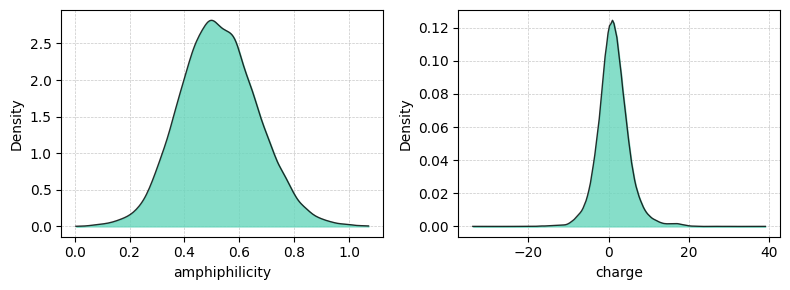

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))


d = random_subset(datasets["UniProt"], n_samples=30_000, seed=42)

amphiphilicity = cache.model("amphiphilicity")
plot_kde(amphiphilicity(d), "amphiphilicity", bandwidth="silverman", ax=axes[0])

charge = cache.model("charge")
plot_kde(charge(d), "charge", bandwidth="silverman", ax=axes[1])

fig.tight_layout()

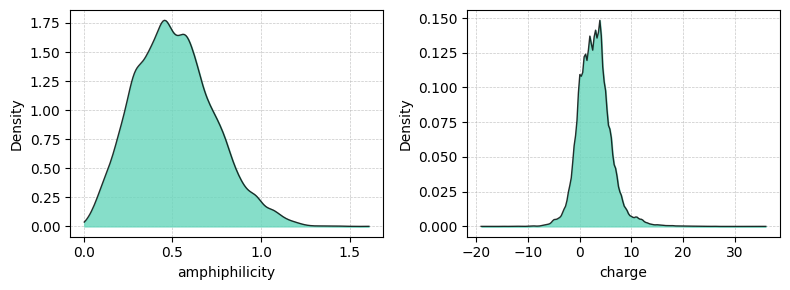

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

d = random_subset(datasets["OmegAMP"], n_samples=30_000, seed=42)

amphiphilicity = cache.model("amphiphilicity")
plot_kde(amphiphilicity(d), "amphiphilicity", bandwidth="silverman", ax=axes[0])

charge = cache.model("charge")
plot_kde(charge(d), "charge", bandwidth="silverman", ax=axes[1])

fig.tight_layout()

Using "Silverman" to estimate the kde bandwidth appears to work well here. Also notice AMPs usually have a positive charge.


Let's select the metrics.


In [ ]:
embedder = "embedder"  # "embedder"


metrics = [
    Uniqueness(),
    Novelty(reference=seqs_train),
    FBD(reference=seqs_amps, embedder=cache.model(embedder)),
    MMD(reference=seqs_amps, embedder=cache.model(embedder)),
    Fold(
        Precision(neighborhood_size=3, reference=seqs_train, embedder=cache.model(embedder), strict=True),
        split_size=len(seqs_train),
        drop_last=True,
    ),
    Fold(
        Recall(neighborhood_size=3, reference=seqs_train, embedder=cache.model(embedder), strict=True),
        split_size=len(seqs_train),
        drop_last=True,
    ),
    # ID(predictor=cache.model("esm2-perplexity"), name="Perplexity", objective="minimize"),
    # @TODO: ID amplify
    # @TODO: ID amPEPpy
    # @TODO: ID y_mic
    Fold(
        AuthPct(train_set=seqs_train, embedder=cache.model(embedder), strict=True),
        split_size=len(seqs_train),
        drop_last=True,
    ),
    # @TODO: FLD (seqs_train)
    ConformityScore(
        reference=seqs_amps,
        descriptors=[cache.model("amphiphilicity"), cache.model("charge")],
        kde_bandwidth="silverman",
    ),
]

`Fold` computes the metrics multiple using different folds, and aggregate the values (mean and standard deviation).

Wrapping `Fold` around the `Precision` and `Recall` metric, removes the sample size bias inherent in these metrics (introduced by k-NN), while still utilizing as many of the available sequences as possible.


## Table


Let's compute the metrics for each group of sequences.


In [ ]:
df = compute_metrics(benchmark_datasets, metrics)

Let's look at the results.


In [ ]:
show_table(df, decimals=[3, 3, 2, 2, 2, 2, 2, 2])

,Uniqueness↑,Novelty↑,FBD↓,MMD↓,Precision↑,Recall↑,Authenticity↑,Conformity score↑
AMP-Diffusion,0.911,0.998,56.24,199.98,1.00,0.62,0.99,0.34±0.00
AMP-GAN,0.996,1.000,3.16,45.11,0.95,0.86,0.95,0.45±0.00
CPL-Diff,0.976,0.986,8.04,13.12,0.92,1.00,0.92,0.41±0.00
HydrAMP,1.000,1.000,16.70,37.58,0.99,0.77,0.99,0.32±0.00
OmegAMP,0.946,0.912,20.21,26.00,0.87,1.00,0.87,0.38±0.00
UniProt,1.000,1.000,358.93,741.10,0.99,0.99,0.98,0.27±0.00


Optional: Saving the cache to a file.


In [ ]:
OUT_CACHE_PATH = "new_cache.pkl"

with open(OUT_CACHE_PATH, "wb") as f:
    pickle.dump(cache.get_cache(), f)